## Setup


In [ ]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 3.0MB 36.6MB/s 
     |████████████████████████████████| 460kB 30.1MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import cv2
from google.colab.patches import cv2_imshow
from keras.layers import Input, Dense, Lambda

print(tf.__version__)
print(cv2.__version__)
print(keras.__version__)

Found GPU at: /device:GPU:0
2.2.0
4.1.2
2.3.0-tf


In [ ]:
# access google file system
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/vae/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load Dataset

In [ ]:
def load_images(file_path):
  raw_image_dataset = tf.data.TFRecordDataset(file_path)

  # Create a dictionary describing the features.
  image_feature_description = {
      'shape': tf.io.FixedLenFeature([3], tf.int64),
      'data': tf.io.FixedLenFeature([], tf.string),
      'label': tf.io.FixedLenFeature([1], tf.int64)
  }

  def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)
  parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
  
  images = []
  for image_features in parsed_image_dataset:
    image_raw = image_features['data'].numpy()
    shape = image_features['shape'].numpy()
    img = tf.io.decode_raw(image_raw, tf.uint8)
    img = tf.reshape(img, shape).numpy()
    images.append(img)
  return np.array(images)

def imshow(img):
  cv2_imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

(75, 256, 256, 3)
(225, 256, 256, 3)


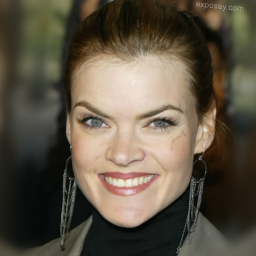

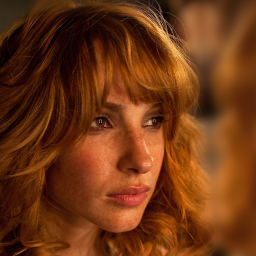

In [ ]:
validation_images = load_images(cwd + 'validation-r08-s-0000-of-0040.tfrecords')
images = load_images(cwd + 'train-r08-s-0000-of-0120.tfrecords')
print(validation_images.shape)
print(images.shape)
imshow(images[0])
imshow(validation_images[0])

## Generate Blur Images

(225, 256, 256, 3)
21.855946964457456


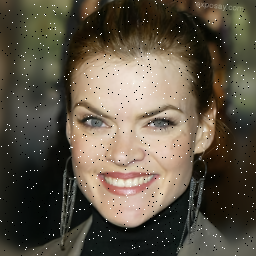

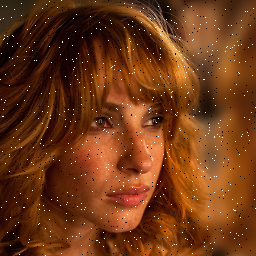

In [ ]:
def gen_blur(images):
  topleft = 100
  size = 64
  blur_imgs = []
  images_copy = np.copy(images)
  for img in images_copy:
    b_img = img[topleft:topleft+size, topleft:topleft+size]
    b_img = cv2.blur(b_img,(20,20))
    for i in range(size):
      for j in range(size):
        img[i+topleft][j+topleft] = b_img[i][j]
    blur_imgs.append(img)
  blur_imgs = np.array(blur_imgs)
  return blur_imgs

'''
NOISE
'''
import random
def noisy(image, prob=0.05):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

def gen_noise(images, prob=0.05):
  noise = []
  for img in images:
    noise.append(noisy(img, prob))
  noise = np.array(noise).astype('uint8')
  return noise
'''
END
'''

blur_imgs = gen_noise(images)
val_blur_imgs = gen_noise(validation_images)
print(blur_imgs.shape)
print(cv2.PSNR(blur_imgs[0], images[0]))
cv2_imshow(cv2.cvtColor(blur_imgs[0], cv2.COLOR_BGR2RGB))
cv2_imshow(cv2.cvtColor(val_blur_imgs[0], cv2.COLOR_BGR2RGB))

## Baseline

In [ ]:
!pip install bm3d
import bm3d

     |████████████████████████████████| 8.4MB 2.5MB/s 


In [ ]:
avg = 0
for i in range(len(val_blur_imgs)):
  avg += cv2.PSNR(val_blur_imgs[i], validation_images[i])
print(avg/len(val_blur_imgs))


avg_denoise = 0
for i in range(len(val_blur_imgs)):
  denoised_image = bm3d.bm3d(val_blur_imgs[i], sigma_psd=1210, 
                            stage_arg=bm3d.BM3DStages.ALL_STAGES).astype('uint8')
  avg_denoise += cv2.PSNR(denoised_image, validation_images[i])
print(avg_denoise/len(val_blur_imgs))

21.721336654805683
15.450183819087757


## Divide and Merge Images

In [ ]:
block_size = 18
block_per_image = 324
shape = (block_size, block_size, 3)
print(block_per_image, shape)

324 (18, 18, 3)


In [ ]:
def divide_img(img, block_size=18, num_block=18, overlap=4):
  height = len(img)
  width = len(img[0])
  if not (block_size*num_block - (num_block - 1)*overlap == height):
    print('Block size mismatch', 
          block_size*num_block - (num_block - 1)*overlap, height)
    return None
  size = block_size - overlap
  blocks = np.array([img[i:i+block_size, j:j+block_size] 
                     for j in range(0,width - overlap,size) 
                     for i in range(0,height - overlap,size)])
  return blocks

def merge_img(blocks, width=256, height=256, block_size=18, overlap=4):
  num_block_per_row = (width - overlap)//(block_size - overlap)
  num_block_per_col = (height - overlap)//(block_size - overlap)
  def get_row_block(row):
    row_block = blocks[row]
    for j in range(1, num_block_per_row):
      cur_row_block = row_block[:, :len(row_block[0]) - overlap]
      block1 = blocks[row+j*num_block_per_col]
      cur_block = block1[:, overlap:]
      lapping = row_block[:, len(row_block[0]) - overlap:]
      lapping1 = block1[:, :overlap]
      for k in range(0, overlap):
        lapping[:, k] *= 1 - (k+1)/(overlap+1)
        lapping1[:, k] *= (k+1)/(overlap+1)
      lap = lapping + lapping1
      row_block = np.concatenate([cur_row_block, lap, cur_block], axis=1)
    return row_block

  img = get_row_block(0)
  for i in range(1, num_block_per_col):
    cur_block = img[:len(img)-overlap]
    cur_row = get_row_block(i)
    lapping = img[len(img)-overlap:]
    lapping1 = cur_row[:overlap]
    cur_row = cur_row[overlap:]
    for k in range(0, overlap):
        lapping[k,:] *= 1 - (k+1)/(overlap+1)
        lapping1[k,:] *= (k+1)/(overlap+1)
    
    lap = lapping + lapping1
    img = np.concatenate([cur_block, lap, cur_row], axis=0)
  return img

In [ ]:
def gen_train_set(clear_imgs, blur_imgs, block_size):
  blur_images = []
  clear_images = []

  for i in range(len(clear_imgs)):
    blocks = divide_img(clear_imgs[i], block_size)
    for b in blocks:
      clear_images.append(b)
    blur_blocks = divide_img(blur_imgs[i], block_size)
    for bb in blur_blocks:
      blur_images.append(bb)
  return np.array(clear_images)/255, np.array(blur_images)/255

clear_images, blur_images = gen_train_set(images, blur_imgs, block_size=block_size)

print(clear_images.shape, blur_images.shape)

(72900, 18, 18, 3) (72900, 18, 18, 3)


## Build the encoder and decoder


In [ ]:
latent_dim = 60
regularizer = keras.regularizers.l1_l2(0.01)

def build_encoder(latent_dim, shape):
  encoder_inputs = keras.Input(shape=shape)
  x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same", 
                    kernel_regularizer=regularizer)(encoder_inputs)
  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same",
                    kernel_regularizer=regularizer)(x)
  x = layers.Conv2D(48, 3, activation="relu", strides=1, padding="same", 
                    kernel_regularizer=regularizer)(x)
  x = layers.Conv2D(72, 3, activation="relu", strides=2, padding="same", 
                    kernel_regularizer=regularizer)(x)
  x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same", 
                    kernel_regularizer=regularizer)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = layers.Flatten()(x)
  x = layers.Dense(96, activation="relu", 
                   kernel_regularizer=regularizer)(x)
  x = layers.Dense(latent_dim, activation="relu", 
                   kernel_regularizer=regularizer)(x)
  encoder = keras.Model(encoder_inputs, x, name="encoder")
  return encoder

encoder = build_encoder(latent_dim, shape)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 18, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 48)          13872     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 72)          31176     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         83072     
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 128)         512 

In [ ]:
def build_decoder(latent_dim, shape, name):
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(shape[0] * shape[1] * 4, activation="relu",
                   kernel_regularizer=regularizer)(latent_inputs)
  x = layers.Reshape((shape[0]//6, shape[1]//6, 144))(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, 
                             kernel_regularizer=regularizer, padding="same")(x)
  x = layers.Conv2DTranspose(72, 3, activation="relu", strides=2,
                             kernel_regularizer=regularizer, padding="same")(x)
  x = layers.Conv2DTranspose(48, 3, activation="relu", strides=1, 
                             kernel_regularizer=regularizer, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=3, 
                             kernel_regularizer=regularizer, padding="same")(x)
  x = layers.Conv2DTranspose(16, 3, activation="relu", strides=1, 
                             kernel_regularizer=regularizer, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(shape[2], 3, 
                                           activation="sigmoid", 
                                           kernel_regularizer=regularizer, 
                                           padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name=name)
  return decoder

decoder = build_decoder(latent_dim, shape,"decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1296)              79056     
_________________________________________________________________
reshape (Reshape)            (None, 3, 3, 144)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 128)         166016    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 6, 6, 72)          83016     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 6, 6, 48)          31152     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 18, 18, 32)        1385

## Clustering

In [ ]:
from typing import List
import numpy as np
import scipy as sp
from sklearn import cluster
from sklearn import decomposition
import sklearn
print(sklearn.__version__)

def cluster_latent(imgs: List[List[float]], num_cluster: int):
  n_clusters = num_cluster 
  np.random.seed(0)
  
  inner_size = len(imgs[0])
  X = np.reshape(imgs,(-1, inner_size))

  k_means = cluster.KMeans(n_clusters=n_clusters, init='random', n_init= 8, random_state=0)
  k_means.fit(X)
  values = k_means.cluster_centers_.squeeze()
  labels = k_means.labels_
  centroids = k_means.cluster_centers_
  inertia = k_means.inertia_
  
  y_kmeans = k_means.fit_predict(X)
  pca =  decomposition.PCA(n_components=2)
  X = pca.fit_transform(X)
  colors = ['red', 'blue', 'green', 'yellow', 'black', 'purple']
  for n in range(n_clusters):
    plt.scatter(X[y_kmeans==n, 0], X[y_kmeans==n, 1], s=5, c=colors[n], label ='Cluster'+str(n))
  plt.show()

  return labels.tolist(), centroids.tolist(), inertia

def gen_clusters(imgs, labels, num_cluster):
  clusters = {}
  for label in labels:
    clusters[label] = []
  for i in range(len(labels)):
    clusters[labels[i]].append(imgs[i])
  return clusters

0.22.2.post1


## Define the VAE as a `Model` with a custom `train_step`


In [ ]:
class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        test = data[0][1]
        data = data[0][0]
        shape = (len(data[0]), len(data[0][0]))

        with tf.GradientTape() as tape:
            z = self.encoder(data)
            
            # reconstruct images
            reconstruction = self.decoder(z)
            # calculate loss
            # labels, centroids, inertia = cluster_latent(z.numpy(),2)
            # inertia *= 0.01
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.MSE(test, reconstruction))
            reconstruction_loss *= shape[0] * shape[1]
            kl = tf.keras.losses.KLDivergence(
                reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
            kl_loss = kl(test, reconstruction)
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "reconstruction_loss": reconstruction_loss,
            #"inertia": inertia,
        }

In [ ]:
class AutoEncoder_P(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder_P, self).__init__(**kwargs)
        self.encoder = encoder
        self.trained_decoder = decoder

    def train_step(self, data):
        test = data[0][1]
        data = data[0][0]
        shape = (len(data[0]), len(data[0][0]))
        
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            # reconstruct images
            reconstruction = self.trained_decoder(z)
            # calculate loss
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.MSE(test, reconstruction))
            reconstruction_loss *= shape[0] * shape[1]
            kl = tf.keras.losses.KLDivergence(
                reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
            kl_loss = kl(test, reconstruction)
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trained_decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trained_decoder.trainable_weights))
        return {
            "reconstruction_loss": reconstruction_loss,
            #"kl_loss": kl_loss,
        }

## Train the VAE


In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)

encoder = build_encoder(latent_dim, shape)
decoder = build_decoder(latent_dim, shape,"decoder")
print(blur_images.shape,clear_images.shape)
model = AutoEncoder(encoder, decoder)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))
model.fit((blur_images,clear_images), epochs=100, batch_size=128)

(72900, 60)


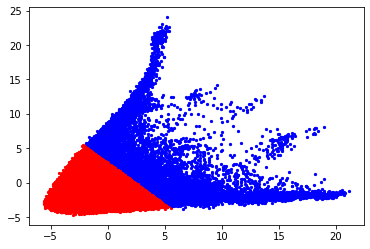

(57919, 18, 18, 3)
<class 'numpy.ndarray'>
(57919, 18, 18, 3)


In [ ]:
# clustering
batch = len(blur_images)//10
z = encoder(blur_images[:batch])
for i in range(batch, len(blur_images), batch):
  z = np.concatenate([z, encoder(blur_images[i: i+batch])], axis=0)
print(z.shape)
labels, centroids, inertia = cluster_latent(z,2)
clusters = gen_clusters(blur_images, labels, 2)
label_clusters = gen_clusters(clear_images, labels, 2)
clus_1 = np.array(clusters[0])
clus_2 = np.array(clusters[1])
label_clus_1 = np.array(label_clusters[0])
label_clus_2 = np.array(label_clusters[1])
print(clus_1.shape)
print(type(clus_1))
print(label_clus_1.shape)

In [ ]:
# train decoder 1
decoder1 = build_decoder(latent_dim, shape,"decoder1")
model_1 = AutoEncoder_P(encoder, decoder1)
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))
model_1.fit((clus_1,label_clus_1), epochs=100, batch_size=128)

Epoch 1/100
453/453 [==============================] - 8s 17ms/step - reconstruction_loss: 3.2604
Epoch 2/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.7021
Epoch 3/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.5834
Epoch 4/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.4770
Epoch 5/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.4383
Epoch 6/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.4232
Epoch 7/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.4110
Epoch 8/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.3969
Epoch 9/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.3922
Epoch 10/100
453/453 [==============================] - 7s 16ms/step - reconstruction_loss: 0.3863
Epoch 11/100
453/45

In [ ]:
# train decoder 2
decoder2 = build_decoder(latent_dim, shape,"decoder2")
model_2 = AutoEncoder_P(encoder, decoder2)
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))
model_2.fit((clus_2,label_clus_2), epochs=100, batch_size=128)

Epoch 1/100
118/118 [==============================] - 2s 17ms/step - reconstruction_loss: 19.7171
Epoch 2/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 3.6597
Epoch 3/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 2.6827
Epoch 4/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 1.8397
Epoch 5/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 1.3275
Epoch 6/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 1.1991
Epoch 7/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 1.1217
Epoch 8/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 0.9967
Epoch 9/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 0.8791
Epoch 10/100
118/118 [==============================] - 2s 16ms/step - reconstruction_loss: 0.8075
Epoch 11/100
118/1

## Evaluation

In [ ]:
def calc_dist(point_a, point_b):
  return np.linalg.norm(point_a - point_b)

def decode_images(z, centroids, decoders):
  decoded_images = []
  decode = []
  for decoder in decoders:
    decode.append(decoder.predict(z))
  for num in range(len(z)):
    i = z[num]
    clus = 0
    min_dist = 999999
    for c in range(len(centroids)):
      if calc_dist(i, centroids[c]) < min_dist:
        clus = c
        min_dist = calc_dist(i, centroids[c])
    decode_img = decode[clus][num]
    decoded_images.append(decode_img)
  return np.array(decoded_images)

def reconstruct_image(z, centroids, decoders, 
                      blocks_per_image=256, img_shape=(256,256), block_size=16):
  recons_images = []
  decoded_images = decode_images(z, centroids, decoders)
  for i in range(0, len(decoded_images), blocks_per_image):
    blocks = decoded_images[i: i+blocks_per_image]
    image = merge_img(blocks, img_shape[0], img_shape[1], block_size)
    recons_images.append(image)
  return np.array(recons_images)

In [ ]:
test_images_clear, test_images_blur = gen_train_set(
    validation_images, val_blur_imgs, block_size=block_size)

z = encoder.predict(test_images_blur)
print(z.shape)
print(centroids)

decoded_imgs = decoder.predict(z)
print(decoded_imgs.shape)
print(type(decoded_imgs))

(24300, 60)
[[1.2512507438659668, 1.1874449253082275, 1.393888235092163, 1.2190784215927124, 1.1636897325515747, 1.8071155548095703, 1.5391391515731812, 0.0020976942032575607, 1.2413944005966187, 1.4343801736831665, 1.1358919143676758, 0.00030833855271339417, 1.602735161781311, 1.4135708808898926, 0.8659688234329224, 2.3876800537109375, 1.3533369302749634, 1.209272861480713, 1.6093766689300537, 0.9532939195632935, 2.9758715629577637, 1.3697819709777832, 0.8433634638786316, 1.8715569972991943, 1.3654906749725342, 1.1333751678466797, 1.9290157556533813, 1.5040184259414673, 1.0693707466125488, 0.9066451191902161, 0.0, 0.8986433744430542, 1.3182967901229858, 1.1769962310791016, 1.6852301359176636, 1.0894579887390137, 0.0017393529415130615, 1.5524835586547852, 1.5566514730453491, 1.690530776977539, 0.9626865983009338, 1.0074602365493774, 1.2327394485473633, 1.4144268035888672, 1.1345405578613281, 0.5953332781791687, 0.9711385369300842, 0.0, 2.4614715576171875, 1.4498857259750366, 1.27060937

In [ ]:
print(block_per_image)

recons_images = reconstruct_image(z, centroids,
                                  decoders=[decoder1, decoder2],
                                  blocks_per_image=block_per_image,
                                  block_size=block_size)
print(recons_images.shape)

comp_images = reconstruct_image(z, centroids, [decoder, decoder],
                                blocks_per_image=block_per_image,
                                block_size=block_size)
comp_images = (comp_images*255).astype('uint8')

test_images = []
for i in range(0, len(test_images_clear), block_per_image):
  test_images.append(merge_img(test_images_clear[i:i+block_per_image], 256, 256, block_size))
test_images = (np.array(test_images)*255).astype('uint8')
print(comp_images.shape)

recons_images = (recons_images*255).astype('uint8')

324
(75, 256, 256, 3)
(75, 256, 256, 3)


## Quality Metric

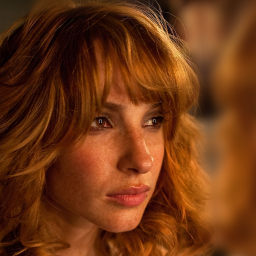

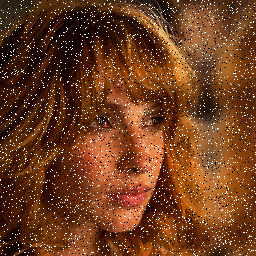

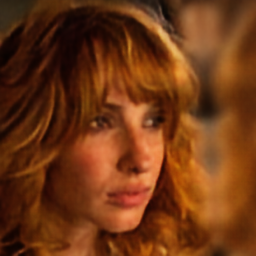

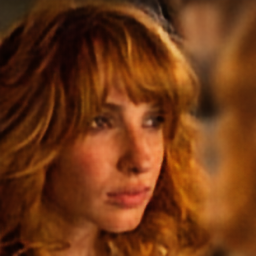

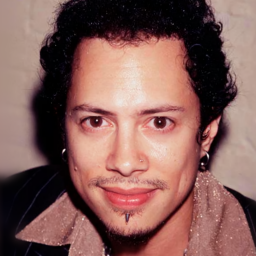

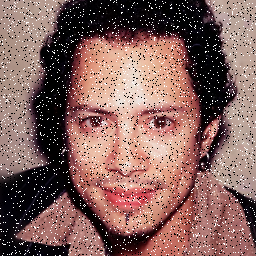

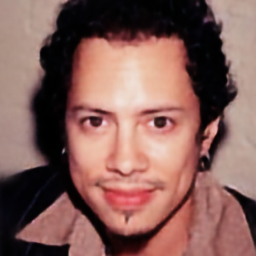

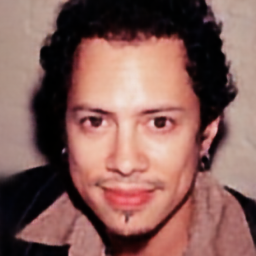

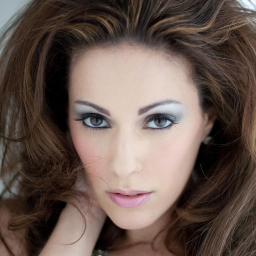

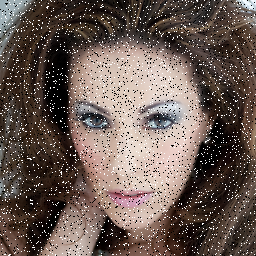

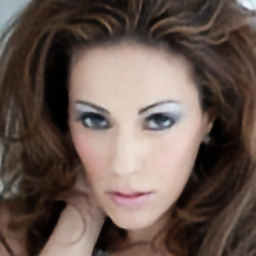

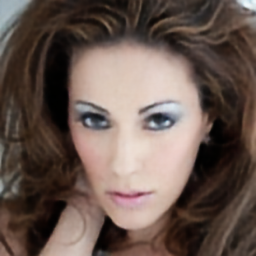

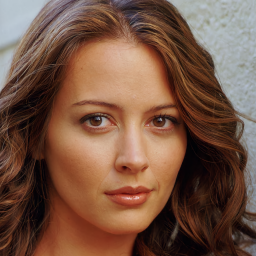

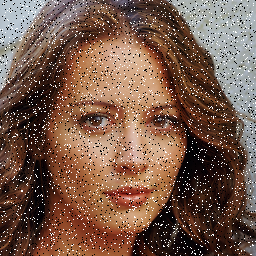

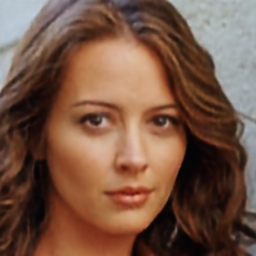

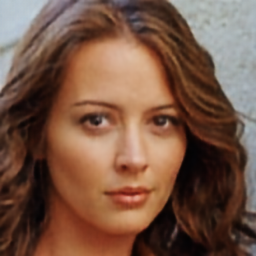

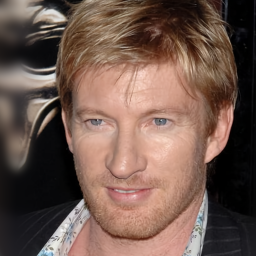

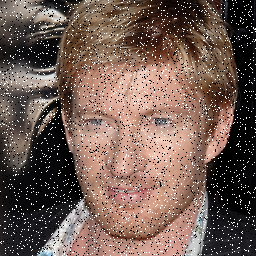

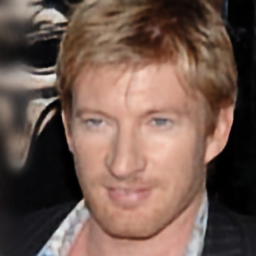

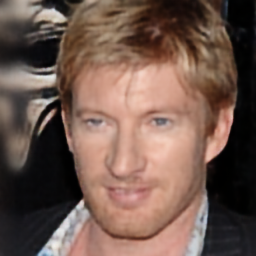

In [ ]:
for n in range(5):
  imshow(test_images[n])
  cv2_imshow(cv2.cvtColor(val_blur_imgs[n], cv2.COLOR_BGR2RGB))
  imshow(comp_images[n])
  imshow(recons_images[n])

In [ ]:
!pip install sewar

  Created wheel for sewar: filename=sewar-0.4.4-cp36-none-any.whl size=10390 sha256=c6ecc0e67bbdd5a0b517ac2e912d275b748a43a1d267582de6a950bb36941d42
  Stored in directory: /root/.cache/pip/wheels/6b/dd/1f/6bde4832a765007d4f58c9d8bbf82a82b263b7b85e58cbe935
Successfully built sewar


In [ ]:
cnt = 0
recons_psnr = []
comp_psnr = []
for i in range(len(recons_images)):
  recons_psnr.append(cv2.PSNR(recons_images[i], test_images[i]))
  comp_psnr.append(cv2.PSNR(comp_images[i], test_images[i]))
  if cv2.PSNR(recons_images[i], test_images[i]) > cv2.PSNR(comp_images[i], test_images[i]):
    cnt += 1
print('PSNR')
print(np.array(recons_psnr).mean(), np.array(comp_psnr).mean())
print(cnt/len(test_images))

from skimage.metrics import structural_similarity as ssim

cnt = 0
recons_ssim = []
comp_ssim = []
for i in range(len(recons_images)):
  recons_ssim.append(ssim(recons_images[i], test_images[i], multichannel=True))
  comp_ssim.append(ssim(comp_images[i], test_images[i], multichannel=True))
  if ssim(recons_images[i], test_images[i], multichannel=True) > ssim(comp_images[i], test_images[i], multichannel=True):
    cnt += 1
print('SSIM')
print(np.array(recons_ssim).mean(), np.array(comp_ssim).mean())
print(cnt/len(test_images))

import sewar
cnt = 0
recons_se = []
comp_se = []
for i in range(len(recons_images)):
  recons_se.append(sewar.full_ref.uqi(recons_images[i], test_images[i], ws=8))
  comp_se.append(sewar.full_ref.uqi(comp_images[i], test_images[i], ws=8))
  if sewar.full_ref.uqi(recons_images[i], test_images[i], 
                        ws=8) > sewar.full_ref.uqi(comp_images[i], test_images[i], ws=8):
    cnt += 1
print('UQI')
print(np.array(recons_se).mean(), np.array(comp_se).mean())
print(cnt/len(test_images))


PSNR
31.226598111922577 31.208867938810307
0.6133333333333333
SSIM
0.8833927220399072 0.8829071202205152
0.6
UQI
0.9827677972708558 0.9834031463709567
0.36
